In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/prices-data-bert-embeddings/embeddings.npy
/kaggle/input/prices-data-bert-embeddings/prices_data_with_BERT_embeddings.csv
/kaggle/input/prices-data-bert-embeddings/__huggingface_repos__.json
/kaggle/input/prices-data-bert-embeddings/metadata.csv


In [2]:
df = pd.read_csv('/kaggle/input/prices-data-bert-embeddings/prices_data_with_BERT_embeddings.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,embeddings
1090,2018-12-26,3819.666748,3893.359619,3769.863770,3857.297607,3857.297607,5326547918,[ 4.1821e-01 2.0728e-01 6.2842e-01 -3.9014e-...
1091,2018-12-27,3854.688477,3874.416992,3645.448486,3654.833496,3654.833496,5130222366,[ 2.0190e-01 1.8896e-01 5.5713e-01 -4.9170e-...
1092,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701,3923.918701,5631554348,[ 2.3706e-01 2.1899e-01 5.6934e-01 -4.1650e-...
1093,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691,3820.408691,4991655917,[ 4.3628e-01 6.8298e-02 5.8105e-01 -3.8794e-...
1094,2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637,3865.952637,4770578575,[ 2.5293e-01 2.3022e-01 5.1025e-01 -5.0146e-...


In [3]:
df['embeddings'][0]

'[ 9.8389e-02 -2.8793e-02  7.7441e-01 -1.8018e-01  4.2310e-01 -5.5145e-02\n -7.9590e-02  5.4395e-01  2.1191e-01  4.0375e-02 -1.7786e-01 -2.0032e-01\n -1.1932e-01  2.9395e-01  7.9498e-03  2.6172e-01  2.5610e-01  6.6406e-02\n -2.3697e-02  5.2521e-02  3.5034e-01 -7.5073e-02  1.5625e-01  2.1094e-01\n  2.1167e-01 -1.9470e-02  1.6699e-01 -1.0822e-01 -1.4221e-01  2.7002e-01\n  3.3521e-01  1.6528e-01 -1.5137e-01 -1.4783e-01  1.9470e-01 -1.1749e-02\n -1.5845e-01 -9.4910e-02 -2.2119e-01 -1.7014e-02 -3.2202e-01 -4.7705e-01\n -6.0516e-02  1.4441e-01 -8.1909e-02 -9.7961e-02  3.1323e-01 -1.4526e-02\n -6.1401e-02  1.0193e-01 -1.5442e-01  3.1274e-01 -2.6294e-01 -2.6465e-01\n -3.7964e-02  7.1338e-01 -1.8262e-01 -6.9238e-01 -4.9866e-02 -2.1606e-01\n  4.2773e-01 -1.9788e-01  7.7881e-02  3.0960e-02 -1.0944e-01 -2.4573e-01\n  1.4160e-01  5.0244e-01 -3.8745e-01  1.7105e-02 -1.5955e-01  1.9922e-01\n  9.3689e-02  1.8188e-01 -9.3384e-02  8.4106e-02 -2.4878e-01  2.8662e-01\n  1.6431e-01  6.2622e-02  7.2266e-02 

In [4]:
len(df['embeddings'][0])

9344

In [5]:
from sklearn.decomposition import PCA
#Convert embeddings from string to numpy arrays
def parse_embedding(embed_str):
    clean_str = embed_str.replace('[','').replace(']','').replace('\n',' ')
    return np.array([float(x) for x in clean_str.split()])
df['embedding_array'] = df['embeddings'].apply(parse_embedding)

embeddings_matrix = np.vstack(df['embedding_array'].values)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

In [15]:
# I have 9344 embeddings. These will be too much for the model and will require
# higher computational cost so apply pca on it to reduce the dimensions into 2
# my eembeddings are in the string format inside the string there is a list such as 
# '[1.0  2.0 \n 3.0....]'. there are \n also so replace them by space and then apply PCA
# and reduce dimensionality components to 2 

# **Random Forest**

MSE:  0.00018372795461538247
RMSE:  0.013554628531073159


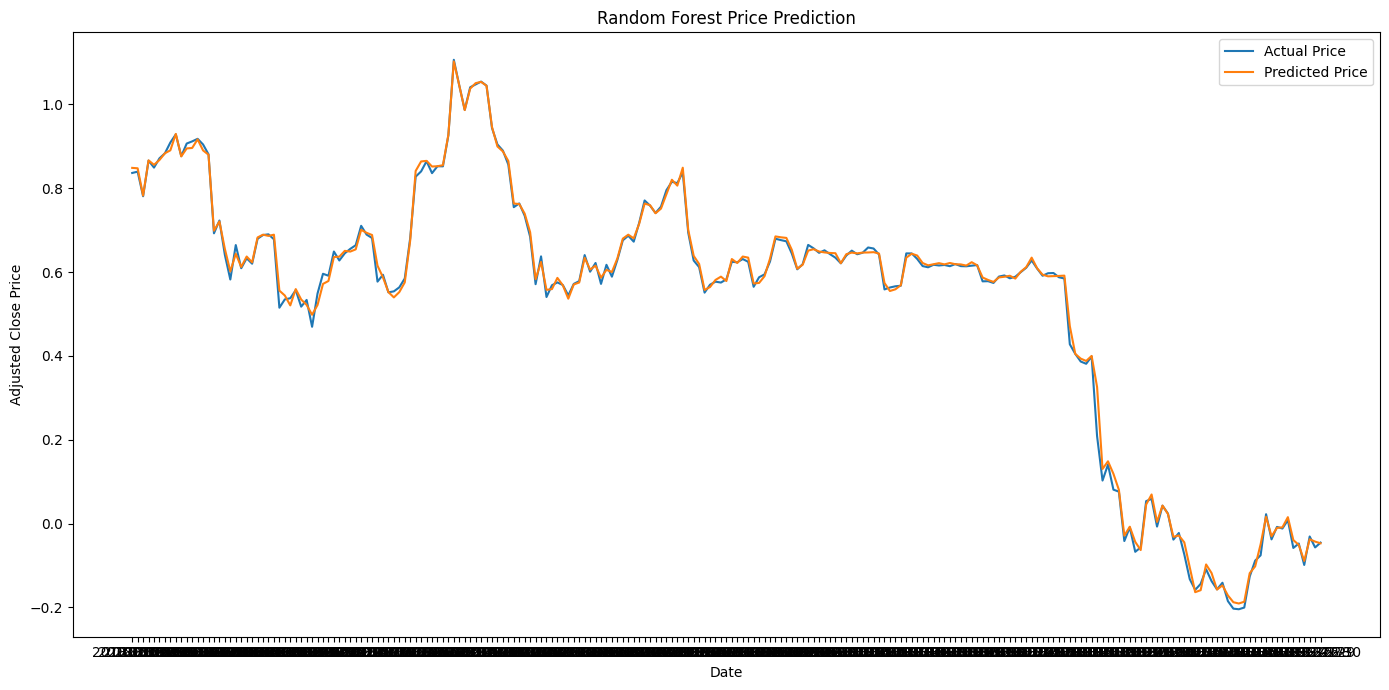

In [6]:
from sklearn.ensemble import RandomForestRegressor

feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
X_features = StandardScaler().fit_transform(df[feature_cols])
X_combined = np.hstack([X_features, reduced_embeddings])
y = StandardScaler().fit_transform(df[['Adj Close']]).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("MSE: ", (mean_squared_error(y_test, y_pred)))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

test_size = len(y_test)
dates = df['Date']
plt.figure(figsize=(14, 7))
plt.plot(dates[-test_size:], y_test, label='Actual Price')
plt.plot(dates[-test_size:], y_pred, label='Predicted Price')
plt.title('Random Forest Price Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# I have my embeddings and tabular data I want to apply Random Forest on it by combining
# both features.
# Combine them and set adj close as target and do train test split
# normalize the tabular features as the values are so large
# dont shuffle the data in train test split as we have to follow sequence in bit coin predictios
# Apply random forest of sklearn on it and compute matrices for model evaluation
# plot the actual and predicted against each other

## **XAI on Random Forest**

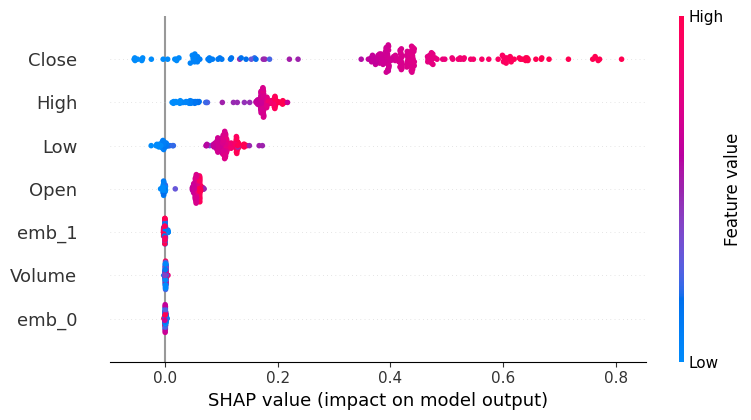

In [7]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test)

tabular_features = ['Open', 'High', 'Low', 'Close', 'Volume']
embedding_features = [f'emb_{i}' for i in range(reduced_embeddings.shape[1])]
all_feature_names = tabular_features + embedding_features

X_test_df = pd.DataFrame(X_test, columns=all_feature_names)

shap.summary_plot(shap_values, X_test_df, max_display=20)

In [18]:
# set a shap variable on random forest and make a summary plot to explain model

## **Feature Importance**

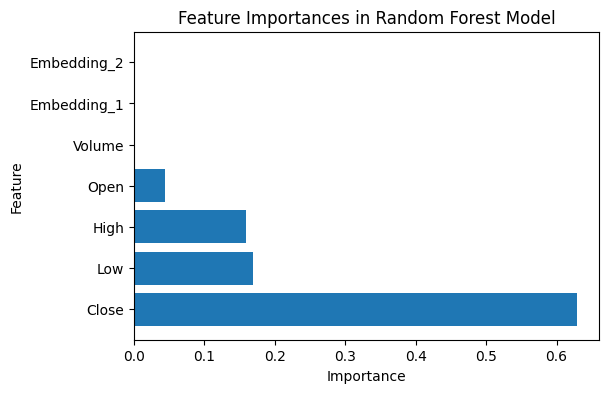

In [8]:
importances = rf.feature_importances_

features = feature_cols + [f'Embedding_{i+1}' for i in range(reduced_embeddings.shape[1])]
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.show()

In [19]:
# compute the importance of each feature and plot it 
# arrange them so that i can get important feature easily

MSE:  0.00010952834017807875
RMSE:  0.010465578826709909


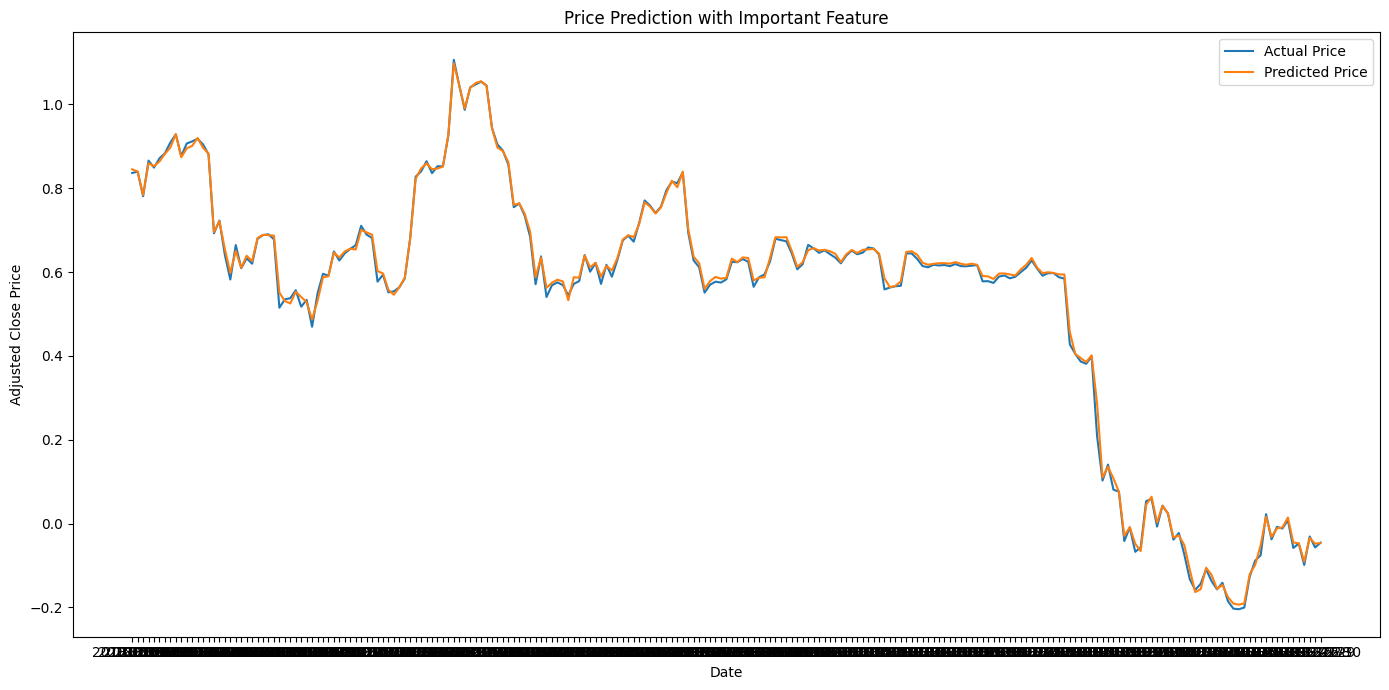

In [9]:
feature_cols = ['High', 'Low', 'Close']
X_features = StandardScaler().fit_transform(df[feature_cols])
X_combined = X_features
y = StandardScaler().fit_transform(df[['Adj Close']]).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, shuffle=False)

rfImp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfImp.fit(X_train, y_train)
y_pred = rfImp.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

test_size = len(y_test)
dates = df['Date']
plt.figure(figsize=(14, 7))
plt.plot(dates[-test_size:], y_test, label='Actual Price')
plt.plot(dates[-test_size:], y_pred, label='Predicted Price')
plt.title('Price Prediction with Important Feature')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# **LSTM**

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.7338 - mae: 0.6888 - val_loss: 0.1171 - val_mae: 0.3033
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0757 - mae: 0.2143 - val_loss: 0.0407 - val_mae: 0.1654
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0446 - mae: 0.1490 - val_loss: 0.0449 - val_mae: 0.1709
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0313 - mae: 0.1046 - val_loss: 0.0413 - val_mae: 0.1596
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298 - mae: 0.0953 - val_loss: 0.0378 - val_mae: 0.1577
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 - mae: 0.0880 - val_loss: 0.0255 - val_mae: 0.1302
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0226 - mae: 0.0812 - val_loss: 0.0175 - val_mae: 0.1029
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0225 - mae: 0.0809 - val_loss: 0.0153 - val_mae: 0.0955
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - mae:

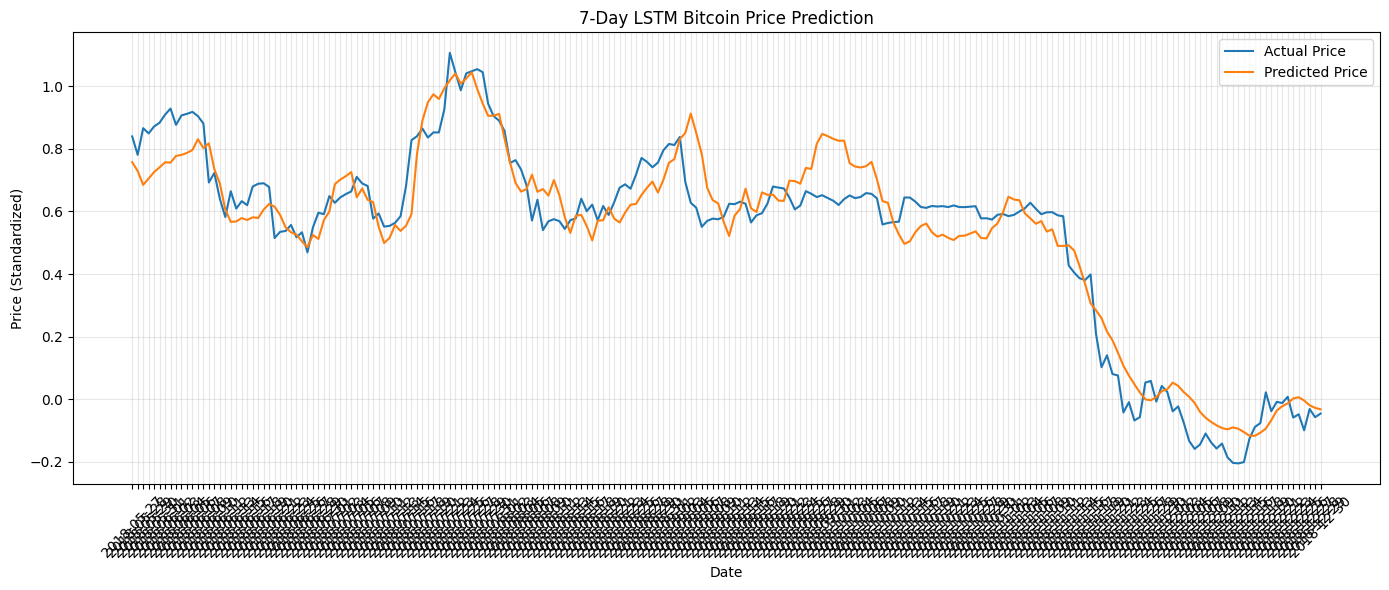

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

scaler = StandardScaler()
tabular_data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
tabular_data_scaled = scaler.fit_transform(tabular_data)

X_combined = np.concatenate([tabular_data_scaled, reduced_embeddings], axis=1)
y = StandardScaler().fit_transform(df[['Adj Close']]).flatten()

def create_sequences(data, targets, window_size=7):
    X, y_seq = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y_seq.append(targets[i])
    return np.array(X), np.array(y_seq)
X_sequences, y_sequences = create_sequences(X_combined, y)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1), LSTM(64), Dense(32, activation='relu'), Dense(1)])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',
              metrics=['mae'])
history = model.fit( X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)
y_pred = model.predict(X_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, MAE: {mae:.4f}')
print('MSE :', mean_squared_error(y_test, y_pred))

test_size = len(y_test)
dates_test = df['Date'].values[-test_size:]
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual Price')
plt.plot(dates_test, y_pred.flatten(), label='Predicted Price')
plt.title('7-Day LSTM Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (Standardized)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Similary as random forest combine tabular and embedding data and split
# use previous data of 7 dayas to capture historical data
# make a sequential lstm model having two hidden layers.
# dont use softmax as activation, use sigmoid or relu which will be the best according to my needs
# Evaluate the model performance and plot actual vs predictions
# add dates along x axis

## **Tunned Lstm**

Trial 10 Complete [00h 00m 06s]
val_loss: 0.025922885164618492

Best val_loss So Far: 0.004829742480069399
Total elapsed time: 00h 01m 13s


Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0561  
Best Hyperparameters:
{'units_lstm_1': 96, 'dropout_1': 0.2, 'units_lstm_2': 96, 'dense_units': 32, 'learning_rate': 0.01}
Test Loss: 0.0048, MAE: 0.0547
Test MSE: 0.004829742225517132


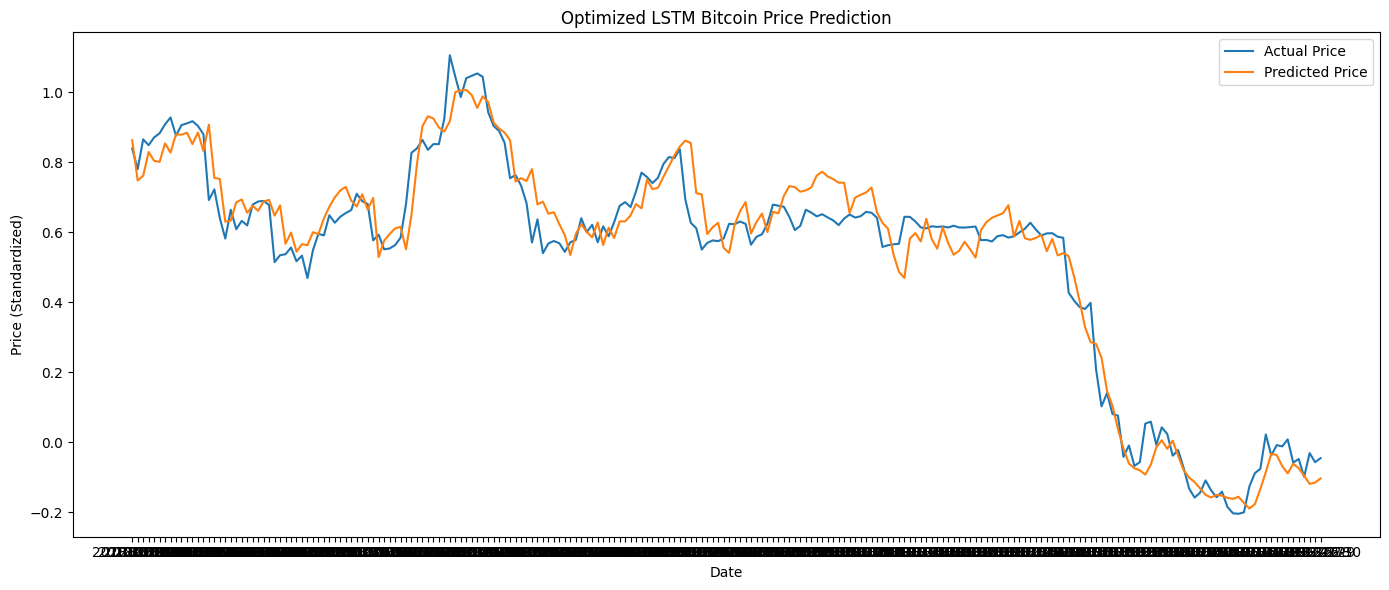

In [11]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Function to create the model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(
        units=hp.Int('units_lstm_1', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # LSTM layer 2
    model.add(LSTM(
        units=hp.Int('units_lstm_2', min_value=32, max_value=128, step=32)
    ))
    
    # Dense layers
    model.add(Dense(units=hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 5e-4, 1e-4])
        ),loss='mean_squared_error', metrics=['mae'] )

    return model

tuner = kt.RandomSearch(
    build_model, objective='val_loss', max_trials=10, executions_per_trial=1
    # directory='lstm_tuner', project_name='bitcoin_price_prediction'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
    callbacks=[early_stop], verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


y_pred = best_model.predict(X_test)
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Hyperparameters:\n{best_hps.values}")
print(f"Test Loss: {loss:.4f}, MAE: {mae:.4f}")
print('Test MSE:', mean_squared_error(y_test, y_pred))

plt.figure(figsize=(14, 6))
plt.plot(df['Date'].values[-len(y_test):], y_test, label='Actual Price')
plt.plot(df['Date'].values[-len(y_test):], y_pred.flatten(), label='Predicted Price')
plt.title('Optimized LSTM Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (Standardized)')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# tune the lstm model using grid search or keras tunner. which will be best
# use early stoping to decide the number of epoches dynamically
# print best hyperparameter values
# it is behaving same as lstm add multiple option in layers so that it can decide its
# neurons which give best results

## **LSTM with Hybrid Fusion**

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6972 - mae: 0.6310 - val_loss: 0.3034 - val_mae: 0.5109
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1144 - mae: 0.2302 - val_loss: 0.0315 - val_mae: 0.1487
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0846 - mae: 0.1859 - val_loss: 0.0131 - val_mae: 0.0843
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0700 - mae: 0.1810 - val_loss: 0.0239 - val_mae: 0.1203
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0667 - mae: 0.1723 - val_loss: 0.0135 - val_mae: 0.0873
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0665 - mae: 0.1606 - val_loss: 0.0135 - val_mae: 0.0876
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0541 - mae: 0.1586 - val_loss: 0.0149 - val_mae: 0.0961
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0495 - mae: 0.1490 - val_loss: 0.0143 - val_mae: 0.0966
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.04

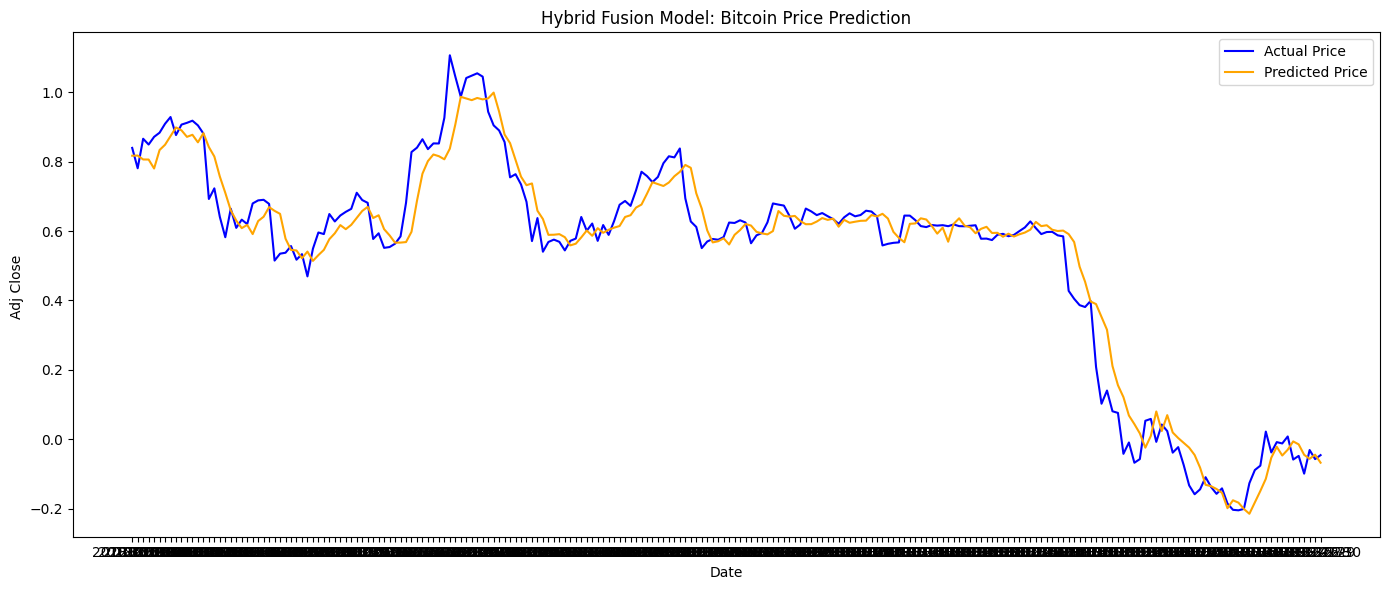

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

scaler = StandardScaler()
tabular = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']].values)
target_scaler = StandardScaler()
y = target_scaler.fit_transform(df[['Adj Close']]).flatten()

def create_sequences(data, y, window_size=7):
    X_seq, y_seq = [], []
    for i in range(window_size, len(data)):
        X_seq.append(data[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)
X_tabular_seq, y_seq = create_sequences(tabular, y)

reduced_embeddings_seq = reduced_embeddings[7:]  # past 7 daus embrddings

X_train_tab, X_test_tab, X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    X_tabular_seq, reduced_embeddings_seq, y_seq, test_size=0.2, shuffle=False
)

# Tabular Branch (LSTM)
tab_input = Input(shape=(X_train_tab.shape[1], X_train_tab.shape[2]))
x1 = LSTM(64, return_sequences=False)(tab_input)
x1 = Dropout(0.3)(x1)
# Embedding Branch (Dense)
emb_input = Input(shape=(X_train_emb.shape[1],))
x2 = Dense(128, activation='relu')(emb_input)
x2 = Dropout(0.3)(x2)
x2 = Dense(64, activation='relu')(x2)

combined = Concatenate()([x1, x2]) # combining for fusion
z = Dense(64, activation='relu')(combined)
z = Dropout(0.2)(z)
output = Dense(1)(z)

model = Model(inputs=[tab_input, emb_input], outputs=output)
model.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit([X_train_tab, X_train_emb], y_train,
    validation_data=([X_test_tab, X_test_emb], y_test), epochs=100, batch_size=32,
    callbacks=[early_stop], verbose=1)

y_pred = model.predict([X_test_tab, X_test_emb])
mse = np.mean((y_pred.flatten() - y_test) ** 2)
mae = np.mean(np.abs(y_pred.flatten() - y_test))
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

test_size = len(y_test)
dates_test = df['Date'].values[-test_size:]
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual Price', color='blue')
plt.plot(dates_test, y_pred.flatten(), label='Predicted Price', color='orange')
plt.title('Hybrid Fusion Model: Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Adj Close ')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# can we apply fustion technique with lstm if yes then how
# which will be the best for my case
# so use hybrid fusion 
# I think we should set lstm model on the tabular data first and then combined it with the
# embeddings for final output. because i think we should capture the tabular context first
# and then combine with embeddings to capture tweet context
# add early stoping in it and also use validation technique as we done previously
# plot a graph of actual and pred againt date
# add evaluation matrices

# **XG Boost**

[0]	validation_0-rmse:0.72361
[1]	validation_0-rmse:0.71649
[2]	validation_0-rmse:0.70876
[3]	validation_0-rmse:0.70174
[4]	validation_0-rmse:0.69456
[5]	validation_0-rmse:0.68790
[6]	validation_0-rmse:0.68120
[7]	validation_0-rmse:0.67472
[8]	validation_0-rmse:0.66773
[9]	validation_0-rmse:0.65935
[10]	validation_0-rmse:0.65294
[11]	validation_0-rmse:0.64651
[12]	validation_0-rmse:0.64035
[13]	validation_0-rmse:0.63359
[14]	validation_0-rmse:0.62742
[15]	validation_0-rmse:0.62130
[16]	validation_0-rmse:0.61500
[17]	validation_0-rmse:0.60913
[18]	validation_0-rmse:0.60309
[19]	validation_0-rmse:0.59714
[20]	validation_0-rmse:0.59134
[21]	validation_0-rmse:0.58566
[22]	validation_0-rmse:0.57940
[23]	validation_0-rmse:0.57360
[24]	validation_0-rmse:0.56746
[25]	validation_0-rmse:0.56140
[26]	validation_0-rmse:0.55548
[27]	validation_0-rmse:0.55036
[28]	validation_0-rmse:0.54492
[29]	validation_0-rmse:0.53933
[30]	validation_0-rmse:0.53364
[31]	validation_0-rmse:0.52844
[32]	validation_0-

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[54]	validation_0-rmse:0.41744
[55]	validation_0-rmse:0.41284
[56]	validation_0-rmse:0.40855
[57]	validation_0-rmse:0.40452
[58]	validation_0-rmse:0.40058
[59]	validation_0-rmse:0.39619
[60]	validation_0-rmse:0.39213
[61]	validation_0-rmse:0.38814
[62]	validation_0-rmse:0.38411
[63]	validation_0-rmse:0.38053
[64]	validation_0-rmse:0.37627
[65]	validation_0-rmse:0.37268
[66]	validation_0-rmse:0.36859
[67]	validation_0-rmse:0.36450
[68]	validation_0-rmse:0.36084
[69]	validation_0-rmse:0.35704
[70]	validation_0-rmse:0.35371
[71]	validation_0-rmse:0.35003
[72]	validation_0-rmse:0.34660
[73]	validation_0-rmse:0.34323
[74]	validation_0-rmse:0.33966
[75]	validation_0-rmse:0.33606
[76]	validation_0-rmse:0.33256
[77]	validation_0-rmse:0.32903
[78]	validation_0-rmse:0.32571
[79]	validation_0-rmse:0.32233
[80]	validation_0-rmse:0.31897
[81]	validation_0-rmse:0.31537
[82]	validation_0-rmse:0.31229
[83]	validation_0-rmse:0.30920
[84]	validation_0-rmse:0.30619
[85]	validation_0-rmse:0.30348
[86]	val

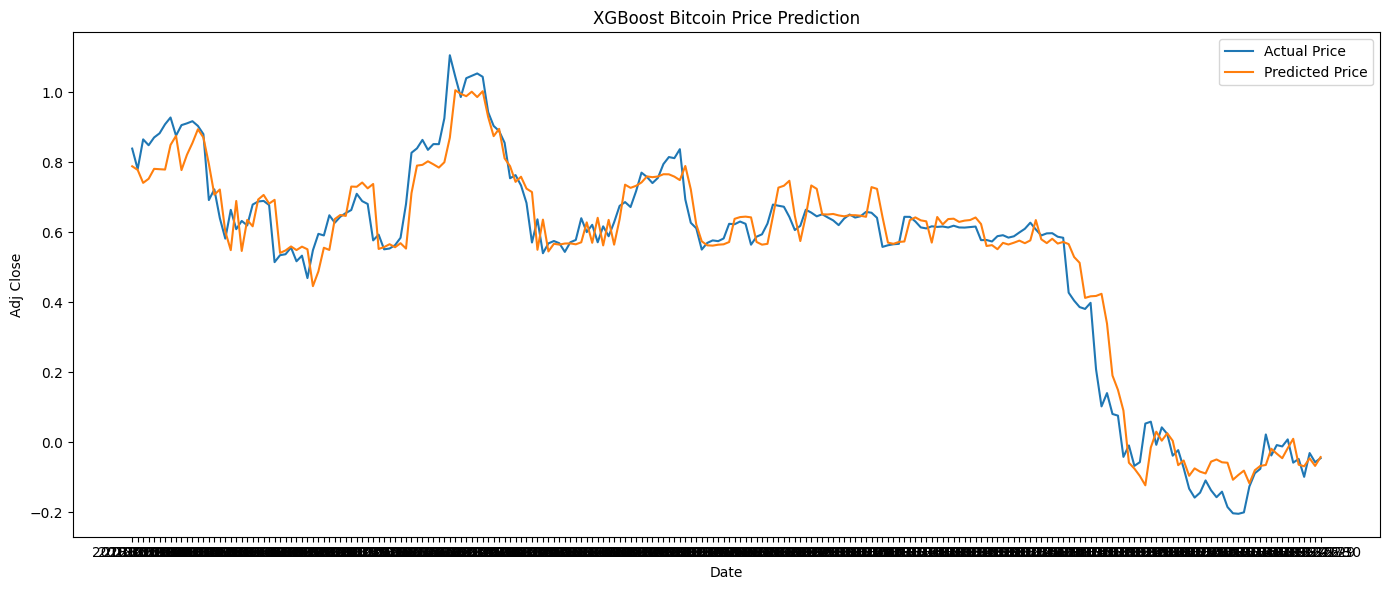

In [13]:
import xgboost as xgb

scaler = StandardScaler()
tabular_data = df[['Open', 'High', 'Low', 'Close',  'Volume']].values
tabular_data_scaled = scaler.fit_transform(tabular_data)
X_combined = np.concatenate([tabular_data_scaled, reduced_embeddings], axis=1)
target_scaler = StandardScaler()
y = target_scaler.fit_transform(df[['Adj Close']]).flatten()

def create_sequences(data, targets, window_size=7):
    X, y_seq = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y_seq.append(targets[i])
    return np.array(X), np.array(y_seq)
X_sequences, y_sequences = create_sequences(X_combined, y)

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, shuffle=False)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, 
                             learning_rate=0.01, max_depth=6, colsample_bytree=0.8, 
                             subsample=0.8)

xgb_model.fit(X_train_reshaped, y_train, eval_metric="rmse", 
              early_stopping_rounds=10, eval_set=[(X_test_reshaped, y_test)], verbose=True)
y_pred = xgb_model.predict(X_test_reshaped)
print('MSE:', mean_squared_error(y_test, y_pred))

test_size = len(y_test)
dates_test = df['Date'].values[-test_size:]
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual Price')
plt.plot(dates_test, y_pred, label='Predicted Price')
plt.title('XGBoost Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# will xg boost will be best for my bitcoin analysis
# built xg boost model on my dataset
# can we give it a sequence as we gave to lstm because as xg boost learn from sequential error
# and correct them 
# I think we need to reshape the features befor feeding into the model 
# Evaluate model performance and plot the graph

## **XAI on XG Boost**

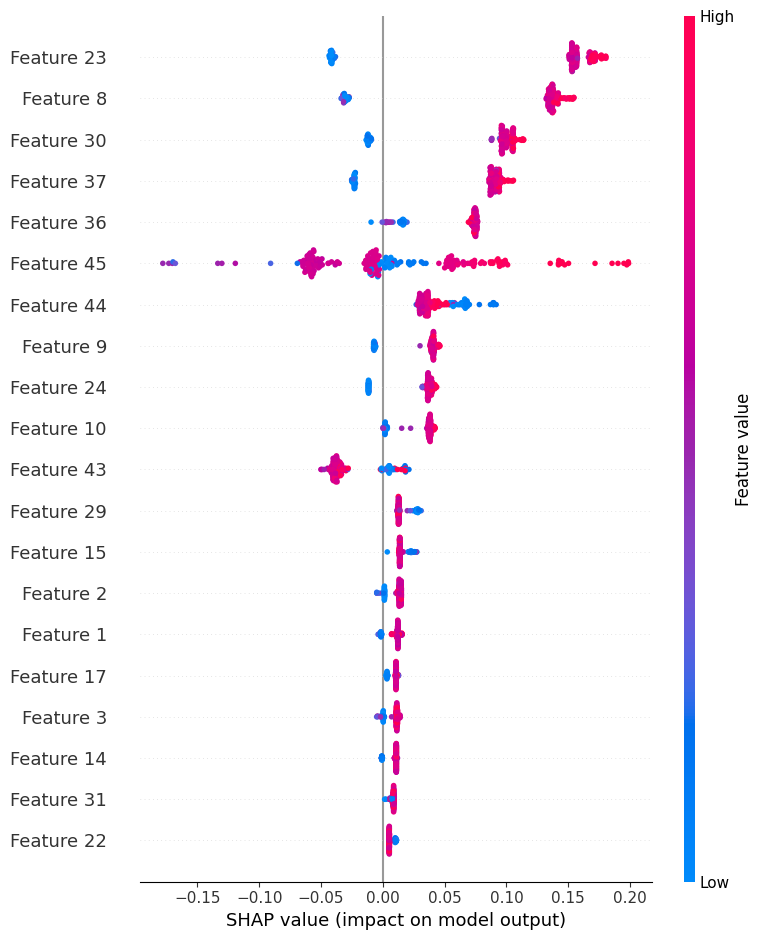

In [14]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_reshaped)
shap.summary_plot(shap_values, X_test_reshaped)

In [ ]:
# apply shap on xg boost
# give a summary plot